In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import optuna


Напишем функцию read_data, который будет приводить dataframe к удобному виду.

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def get_various_params_data(data: pd.DataFrame):
    return (data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 80)])

In [5]:
def get_features_and_target(velocity: float, load: bool, n_cols) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [6]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X_transformed = np.array(np.abs(rfft(X[0, :])))
    for i in range(1, X.shape[0]):
        X_transformed = np.vstack((X_transformed, np.abs(rfft(X[i, :]))))
    data = pd.DataFrame(X_transformed, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [7]:
vel_list = [8.33203125, 25.0, 40.0]
data = get_features_and_target(velocity=vel_list[0], load=False, n_cols=150)
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.501598,3.501949,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.503456,3.504162,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.502249,3.503900,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503313,3.503553,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502371,3.503005,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.497177,3.498452,3.497983,3.498930,3.497532,3.497790,3.497282,3.498127,3.499732,...,3.497160,3.500196,3.498114,3.497177,3.497135,3.499061,3.498570,3.498228,3.496861,3.496414
992,tooth_chipped_fault,3.500674,3.499157,3.498456,3.497869,3.496113,3.499846,3.499850,3.497422,3.498233,...,3.500691,3.498896,3.498478,3.500188,3.499833,3.497663,3.499508,3.499340,3.499390,3.498934
993,tooth_chipped_fault,3.499111,3.497190,3.500061,3.500978,3.499394,3.498794,3.498085,3.498241,3.499271,...,3.497663,3.498786,3.498254,3.496911,3.496248,3.498605,3.496256,3.497347,3.497181,3.499947
994,tooth_chipped_fault,3.499390,3.496341,3.497887,3.497654,3.499605,3.498583,3.496261,3.497747,3.499065,...,3.497734,3.497861,3.498773,3.498427,3.497958,3.497958,3.498533,3.497967,3.496113,3.498782


<Axes: >

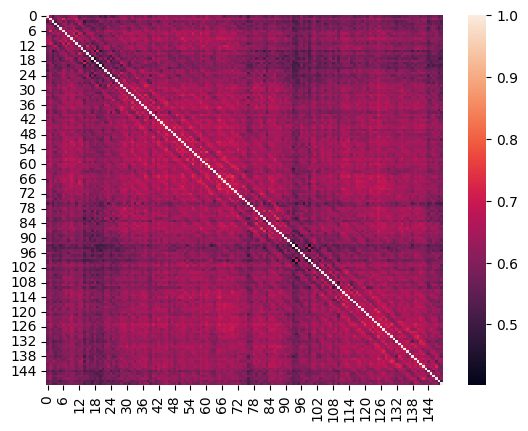

In [8]:
sns.heatmap(data.drop(columns='defect').corr())

In [9]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.501598,3.501949,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.503456,3.504162,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.502249,3.503900,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503313,3.503553,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502371,3.503005,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.497177,3.498452,3.497983,3.498930,3.497532,3.497790,3.497282,3.498127,3.499732,...,3.497160,3.500196,3.498114,3.497177,3.497135,3.499061,3.498570,3.498228,3.496861,3.496414
992,tooth_chipped_fault,3.500674,3.499157,3.498456,3.497869,3.496113,3.499846,3.499850,3.497422,3.498233,...,3.500691,3.498896,3.498478,3.500188,3.499833,3.497663,3.499508,3.499340,3.499390,3.498934
993,tooth_chipped_fault,3.499111,3.497190,3.500061,3.500978,3.499394,3.498794,3.498085,3.498241,3.499271,...,3.497663,3.498786,3.498254,3.496911,3.496248,3.498605,3.496256,3.497347,3.497181,3.499947
994,tooth_chipped_fault,3.499390,3.496341,3.497887,3.497654,3.499605,3.498583,3.496261,3.497747,3.499065,...,3.497734,3.497861,3.498773,3.498427,3.497958,3.497958,3.498533,3.497967,3.496113,3.498782


In [10]:
data = do_rfft_features(data)
data

,defect,0,1,2,3,4,5,6,7,8,...,66,67,68,69,70,71,72,73,74,75
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.017426,0.009864,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007742,0.014931,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.015434,0.007726,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.006287,0.013581,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.006371,0.003422,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,524.695039,0.019862,0.021527,0.009808,0.014179,0.004442,0.015226,0.033520,0.009590,...,0.004452,0.002674,0.011170,0.006236,0.003758,0.002896,0.014301,0.014834,0.010840,0.008288
992,tooth_chipped_fault,524.742320,0.021972,0.016505,0.022731,0.012580,0.009677,0.016619,0.028394,0.004185,...,0.022369,0.002764,0.010747,0.013518,0.002206,0.019882,0.006761,0.011706,0.008779,0.001591
993,tooth_chipped_fault,524.664310,0.033783,0.030214,0.017768,0.013314,0.009979,0.018182,0.011033,0.016066,...,0.010095,0.014097,0.014892,0.010253,0.006014,0.008181,0.006215,0.004355,0.008255,0.013628
994,tooth_chipped_fault,524.689981,0.014892,0.012955,0.006720,0.012757,0.012465,0.006211,0.012619,0.007140,...,0.010432,0.011550,0.001359,0.006780,0.006169,0.011504,0.011995,0.006252,0.012379,0.006754


<Axes: >

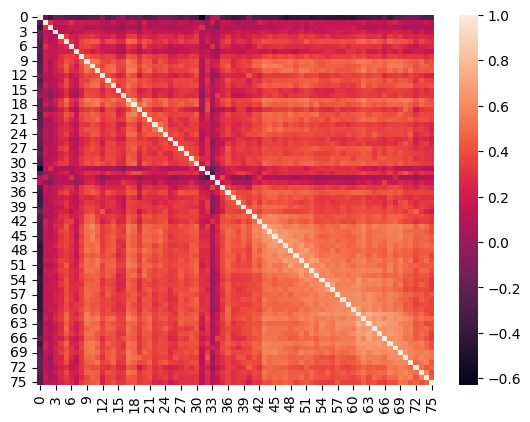

In [11]:
sns.heatmap(data.drop(columns='defect').corr())

In [12]:
X = data.drop(columns=['defect'])
y = data['defect']

In [13]:
y.unique()

array(['eccentricity', 'missing_tooth', 'no_fault', 'root_crack',
       'surface_fault', 'tooth_chipped_fault'], dtype=object)

In [96]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
    X = data.drop(columns=['defect'])
    
    y = data['defect']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy
    

In [98]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

[I 2024-03-24 17:06:19,462] A new study created in memory with name: no-name-b842a730-22ee-4734-835a-2adafce4ea2b
[I 2024-03-24 17:06:19,822] Trial 0 finished with value: 0.9839357429718876 and parameters: {'learning_rate': 0.3920265941423372, 'num_leaves': 2791, 'reg_lambda': 0.6906830824995798, 'min_child_samples': 44}. Best is trial 0 with value: 0.9839357429718876.
[I 2024-03-24 17:06:19,953] Trial 1 finished with value: 0.9839357429718876 and parameters: {'learning_rate': 0.1730520667370454, 'num_leaves': 734, 'reg_lambda': 0.7799735766826174, 'min_child_samples': 88}. Best is trial 0 with value: 0.9839357429718876.
[I 2024-03-24 17:06:20,188] Trial 2 finished with value: 0.9799196787148594 and parameters: {'learning_rate': 0.04497690324175526, 'num_leaves': 1633, 'reg_lambda': 0.6757017759268013, 'min_child_samples': 93}. Best is trial 0 with value: 0.9839357429718876.
[I 2024-03-24 17:06:20,371] Trial 3 finished with value: 0.9799196787148594 and parameters: {'learning_rate': 0.

[I 2024-03-24 17:06:35,367] Trial 32 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.5769697723844388, 'num_leaves': 2235, 'reg_lambda': 0.9090517700252587, 'min_child_samples': 86}. Best is trial 18 with value: 0.9919678714859438.
[I 2024-03-24 17:06:36,211] Trial 33 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.8528422990839233, 'num_leaves': 3023, 'reg_lambda': 0.9739607765790502, 'min_child_samples': 61}. Best is trial 18 with value: 0.9919678714859438.
[I 2024-03-24 17:06:36,853] Trial 34 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.7557884096221698, 'num_leaves': 2616, 'reg_lambda': 0.8244124279014821, 'min_child_samples': 48}. Best is trial 18 with value: 0.9919678714859438.
[I 2024-03-24 17:06:37,079] Trial 35 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.31107519565827024, 'num_leaves': 8, 'reg_lambda': 0.8929563301640981, 'min_child_samples': 38}. Best is tri

[I 2024-03-24 17:06:55,901] Trial 64 finished with value: 0.9839357429718876 and parameters: {'learning_rate': 0.8063780960446844, 'num_leaves': 2831, 'reg_lambda': 0.7862099711685547, 'min_child_samples': 71}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:06:56,688] Trial 65 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.6542782106083782, 'num_leaves': 3079, 'reg_lambda': 0.6893797446819765, 'min_child_samples': 67}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:06:57,362] Trial 66 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.8205407673421143, 'num_leaves': 2687, 'reg_lambda': 0.8506760297308891, 'min_child_samples': 59}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:06:58,018] Trial 67 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.7306316120788687, 'num_leaves': 2022, 'reg_lambda': 0.9065125700562079, 'min_child_samples': 85}. Best is t

[I 2024-03-24 17:07:17,992] Trial 96 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.6933856178750322, 'num_leaves': 2956, 'reg_lambda': 0.7634056532798552, 'min_child_samples': 97}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:18,515] Trial 97 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.7640559883277238, 'num_leaves': 2146, 'reg_lambda': 0.8028411481702246, 'min_child_samples': 67}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:19,099] Trial 98 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.8104107389605194, 'num_leaves': 2393, 'reg_lambda': 0.7861793613679903, 'min_child_samples': 91}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:19,976] Trial 99 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.9749347164765529, 'num_leaves': 3592, 'reg_lambda': 0.8575852210413937, 'min_child_samples': 59}. Best is t

[I 2024-03-24 17:07:37,800] Trial 128 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.6745204035308016, 'num_leaves': 2488, 'reg_lambda': 0.8350112336060675, 'min_child_samples': 79}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:38,447] Trial 129 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.9150384948262579, 'num_leaves': 2718, 'reg_lambda': 0.8032909456312295, 'min_child_samples': 72}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:38,691] Trial 130 finished with value: 0.9799196787148594 and parameters: {'learning_rate': 1.0504913362362498, 'num_leaves': 499, 'reg_lambda': 0.8686622000273755, 'min_child_samples': 77}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:07:39,368] Trial 131 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.895826900054576, 'num_leaves': 2797, 'reg_lambda': 0.8534937491361815, 'min_child_samples': 98}. Best is

[I 2024-03-24 17:07:59,312] Trial 160 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.5868634428048882, 'num_leaves': 3406, 'reg_lambda': 0.4170481260125716, 'min_child_samples': 76}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:00,079] Trial 161 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.8957736504769578, 'num_leaves': 2889, 'reg_lambda': 0.812320704745475, 'min_child_samples': 84}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:00,748] Trial 162 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.841782200478716, 'num_leaves': 2689, 'reg_lambda': 0.8588810492837856, 'min_child_samples': 91}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:01,486] Trial 163 finished with value: 0.9799196787148594 and parameters: {'learning_rate': 0.9818829631206658, 'num_leaves': 3092, 'reg_lambda': 0.7897766571681641, 'min_child_samples': 99}. Best is

[I 2024-03-24 17:08:22,561] Trial 192 finished with value: 0.9959839357429718 and parameters: {'learning_rate': 0.8468964940793122, 'num_leaves': 2974, 'reg_lambda': 0.8080769278038202, 'min_child_samples': 93}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:23,319] Trial 193 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.8440232966697655, 'num_leaves': 2945, 'reg_lambda': 0.8119241101544064, 'min_child_samples': 100}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:24,107] Trial 194 finished with value: 0.9919678714859438 and parameters: {'learning_rate': 0.7995807500766373, 'num_leaves': 3023, 'reg_lambda': 0.8050285993823666, 'min_child_samples': 94}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:24,768] Trial 195 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.7079324336506304, 'num_leaves': 2867, 'reg_lambda': 0.843916718665281, 'min_child_samples': 96}. Best 

[I 2024-03-24 17:08:45,800] Trial 224 finished with value: 0.9879518072289156 and parameters: {'learning_rate': 0.8458112674313584, 'num_leaves': 2956, 'reg_lambda': 0.6172092026067507, 'min_child_samples': 93}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:46,519] Trial 225 finished with value: 0.9959839357429718 and parameters: {'learning_rate': 0.9121228323905619, 'num_leaves': 2632, 'reg_lambda': 0.560190779460492, 'min_child_samples': 91}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:47,160] Trial 226 finished with value: 0.9959839357429718 and parameters: {'learning_rate': 0.9249576526844037, 'num_leaves': 2631, 'reg_lambda': 0.6210980502758368, 'min_child_samples': 90}. Best is trial 44 with value: 0.9959839357429718.
[I 2024-03-24 17:08:47,804] Trial 227 finished with value: 0.9799196787148594 and parameters: {'learning_rate': 0.9324693580042631, 'num_leaves': 2594, 'reg_lambda': 0.5421580501813109, 'min_child_samples': 91}. Best i

In [99]:
print(study.best_params)

{'learning_rate': 0.8814586632393469, 'num_leaves': 2290, 'reg_lambda': 0.9668567222949773, 'min_child_samples': 76}


In [14]:
best_params = {'learning_rate': 0.8814586632393469, 'num_leaves': 2290, 'reg_lambda': 0.9668567222949773, 'min_child_samples': 76}

In [15]:
clf = LGBMClassifier(verbose=-1, **best_params)

X = data.drop(columns=['defect'])
y = data['defect']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [16]:
accuracy

0.9959839357429718

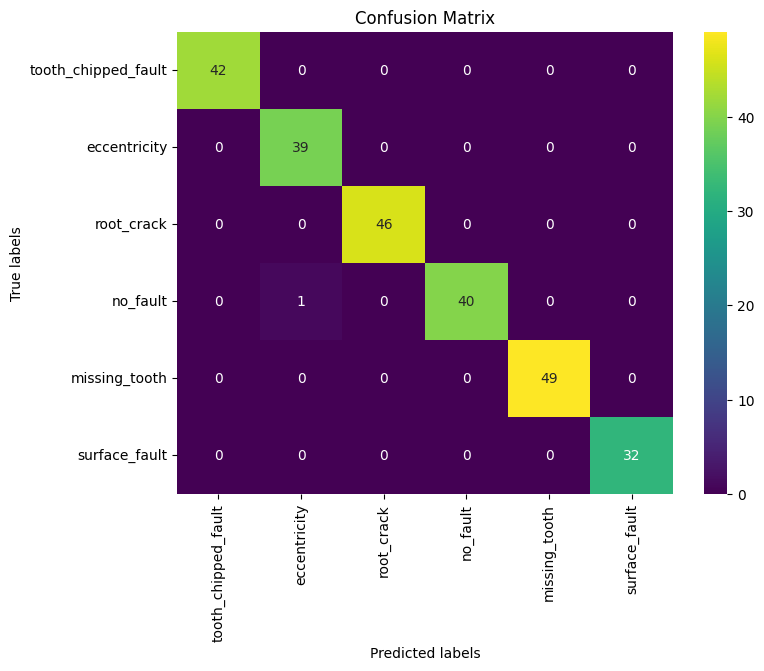

In [17]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
vel_list = [8.33203125, 25.0, 40.0]
data_eccentricity = read_data_and_choose('eccentricity.csv', velocity=vel_list[0], load=False)
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
data_eccentricity

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.522315,2.431974,3.503794,8.332031,0,eccentricity
1,0.0002,2.523629,2.431317,3.504284,8.332031,0,eccentricity
2,0.0004,2.522644,2.428032,3.501296,8.332031,0,eccentricity
3,0.0006,2.521987,2.430660,3.502646,8.332031,0,eccentricity
4,0.0008,2.522808,2.430168,3.502895,8.332031,0,eccentricity
...,...,...,...,...,...,...,...
24995,4.9990,2.522479,2.431153,3.503342,8.332031,0,eccentricity
24996,4.9992,2.520180,2.432631,3.502713,8.332031,0,eccentricity
24997,4.9994,2.522644,2.427704,3.501068,8.332031,0,eccentricity
24998,4.9996,2.524286,2.430496,3.504188,8.332031,0,eccentricity


In [19]:
data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity=vel_list[0], load=False)
missing_tooth_time = data_missing_tooth['time']
missing_tooth_disp = data_missing_tooth['displacements']
data_missing_tooth

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.520016,2.430496,3.501113,8.332031,0,missing tooth
1,0.0002,2.521822,2.430660,3.502527,8.332031,0,missing tooth
2,0.0004,2.519194,2.429511,3.499837,8.332031,0,missing tooth
3,0.0006,2.519851,2.428853,3.499854,8.332031,0,missing tooth
4,0.0008,2.518701,2.429346,3.499369,8.332031,0,missing tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.519851,2.430168,3.500766,8.332031,0,missing tooth
24996,4.9992,2.520673,2.429018,3.500560,8.332031,0,missing tooth
24997,4.9994,2.519358,2.428032,3.498930,8.332031,0,missing tooth
24998,4.9996,2.520508,2.428689,3.500213,8.332031,0,missing tooth


In [20]:
data_no_fault = read_data_and_choose('no_fault.csv', velocity=vel_list[0], load=False)
no_fault_time = data_no_fault['time']
no_fault_disp = data_no_fault['displacements']
data_no_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.523465,2.430168,3.503368,8.332031,0,No fault
1,0.0002,2.521494,2.430003,3.501835,8.332031,0,No fault
2,0.0004,2.522479,2.429675,3.502317,8.332031,0,No fault
3,0.0006,2.521330,2.431810,3.502971,8.332031,0,No fault
4,0.0008,2.522479,2.431317,3.503456,8.332031,0,No fault
...,...,...,...,...,...,...,...
24995,4.9990,2.520508,2.429839,3.501011,8.332031,0,No fault
24996,4.9992,2.520016,2.431153,3.501569,8.332031,0,No fault
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,No fault
24998,4.9996,2.521165,2.432960,3.503651,8.332031,0,No fault


In [21]:
data_root_crack = read_data_and_choose('root_crack.csv', velocity=vel_list[0], load=False)
root_crack_time = data_root_crack['time']
root_crack_disp = data_root_crack['displacements']
data_root_crack

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.519358,2.429675,3.500070,8.332031,0,Root crack
1,0.0002,2.519358,2.429839,3.500184,8.332031,0,Root crack
2,0.0004,2.521165,2.430496,3.501940,8.332031,0,Root crack
3,0.0006,2.520508,2.428853,3.500327,8.332031,0,Root crack
4,0.0008,2.519358,2.428689,3.499385,8.332031,0,Root crack
...,...,...,...,...,...,...,...
24995,4.9990,2.521494,2.429839,3.501721,8.332031,0,Root crack
24996,4.9992,2.520837,2.430496,3.501704,8.332031,0,Root crack
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,Root crack
24998,4.9996,2.520837,2.429182,3.500792,8.332031,0,Root crack


In [22]:
data_surface_fault = read_data_and_choose('surface_fault.csv', velocity=vel_list[0], load=False)
surface_fault_time = data_surface_fault['time']
surface_fault_disp = data_surface_fault['displacements']
data_surface_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.521001,2.427539,3.499771,8.332031,0,surface defect
1,0.0002,2.519851,2.428196,3.499398,8.332031,0,surface defect
2,0.0004,2.520016,2.426225,3.498149,8.332031,0,surface defect
3,0.0006,2.520016,2.428689,3.499859,8.332031,0,surface defect
4,0.0008,2.521165,2.427047,3.499547,8.332031,0,surface defect
...,...,...,...,...,...,...,...
24995,4.9990,2.515581,2.430989,3.498264,8.332031,0,surface defect
24996,4.9992,2.491928,2.441173,3.488413,8.332031,0,surface defect
24997,4.9994,2.545804,2.416206,3.509867,8.332031,0,surface defect
24998,4.9996,2.518537,2.439694,3.506442,8.332031,0,surface defect


In [23]:
data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity=vel_list[0], load=False)
tooth_chipped_fault_time = data_tooth_chipped_fault['time']
tooth_chipped_fault_disp = data_tooth_chipped_fault['displacements']
data_tooth_chipped_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.518209,2.430496,3.499812,8.332031,0,chipped tooth
1,0.0002,2.517880,2.429839,3.499120,8.332031,0,chipped tooth
2,0.0004,2.516402,2.427211,3.496231,8.332031,0,chipped tooth
3,0.0006,2.518537,2.427704,3.498110,8.332031,0,chipped tooth
4,0.0008,2.518701,2.427539,3.498114,8.332031,0,chipped tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.516895,2.428361,3.497384,8.332031,0,chipped tooth
24996,4.9992,2.519030,2.429018,3.499377,8.332031,0,chipped tooth
24997,4.9994,2.519030,2.426882,3.497895,8.332031,0,chipped tooth
24998,4.9996,2.518209,2.430003,3.499470,8.332031,0,chipped tooth


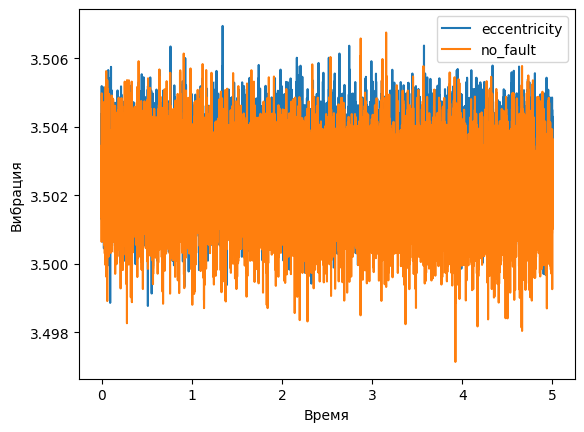

In [24]:
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

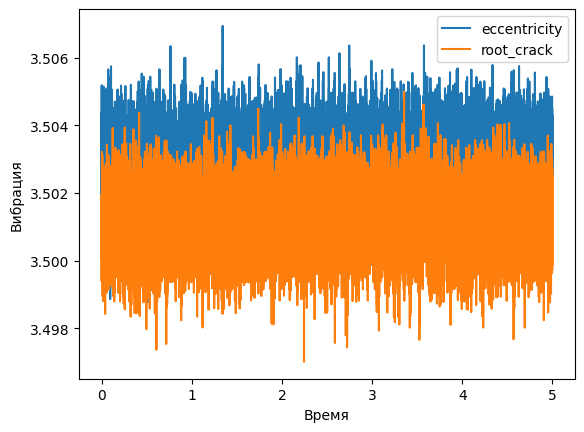

In [25]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(root_crack_time, root_crack_disp, label='root_crack')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

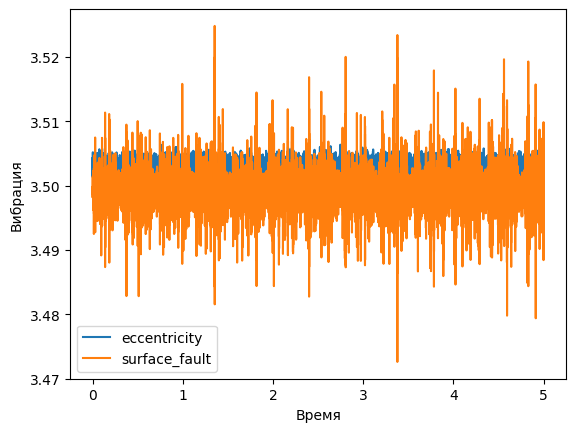

In [26]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(surface_fault_time, surface_fault_disp, label='surface_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

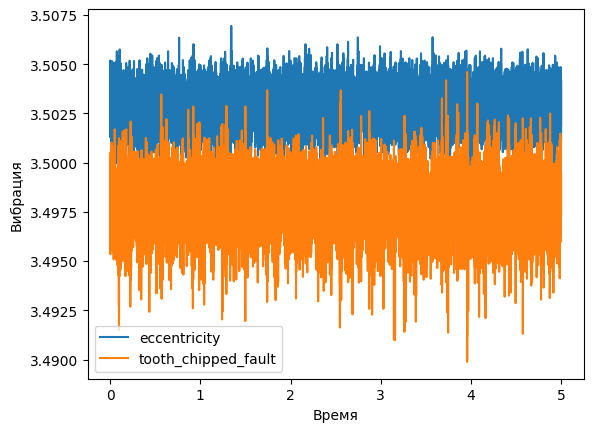

In [27]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(tooth_chipped_fault_time, tooth_chipped_fault_disp, label='tooth_chipped_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

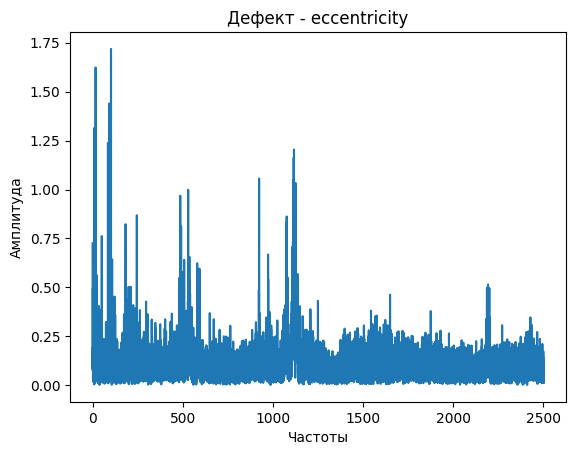

In [28]:
yf = rfft(eccentricity_disp.values)
xf = rfftfreq(n=eccentricity_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - eccentricity')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

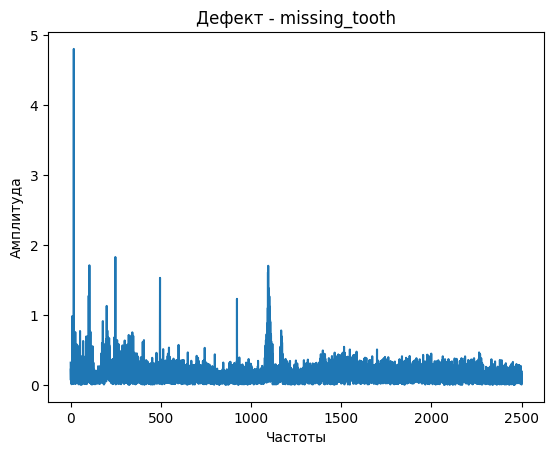

In [29]:
yf = rfft(missing_tooth_disp.values)
xf = rfftfreq(n=missing_tooth_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - missing_tooth')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

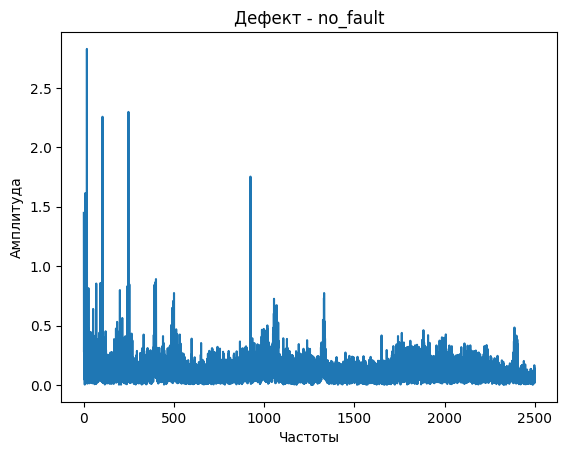

In [30]:
yf = rfft(no_fault_disp.values)
xf = rfftfreq(n=no_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - no_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

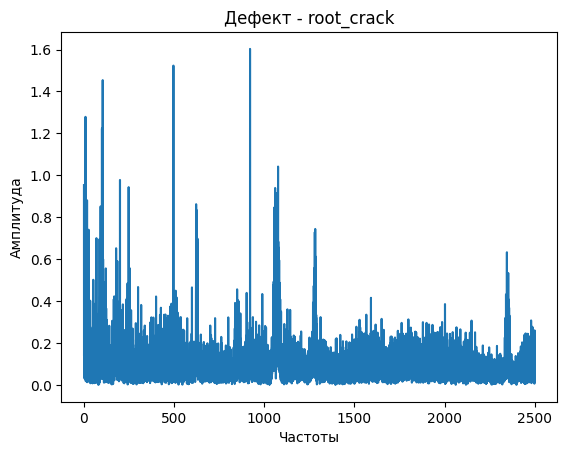

In [31]:
yf = rfft(root_crack_disp.values)
xf = rfftfreq(n=root_crack_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - root_crack')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

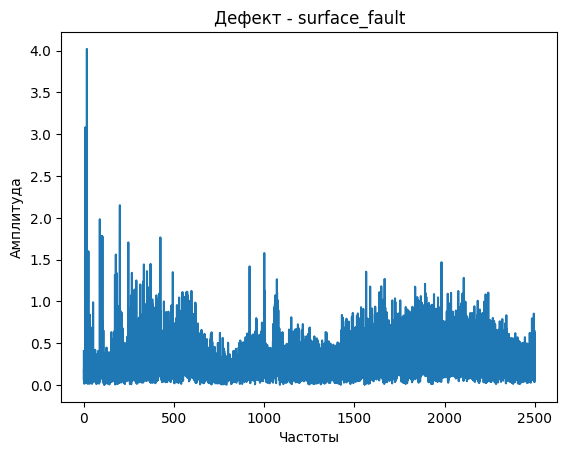

In [32]:
yf = rfft(surface_fault_disp.values)
xf = rfftfreq(n=surface_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - surface_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

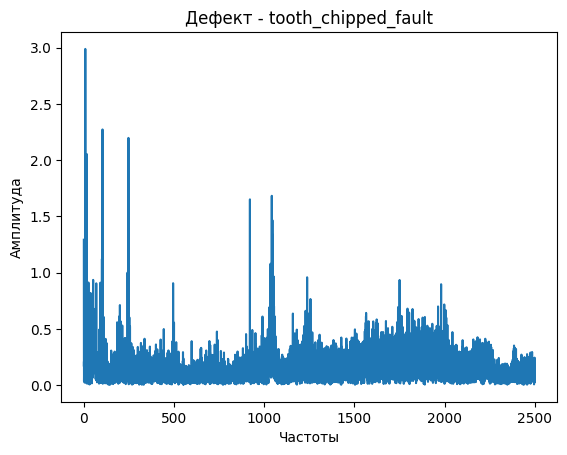

In [33]:
yf = rfft(tooth_chipped_fault_disp.values)
xf = rfftfreq(n=tooth_chipped_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - tooth_chipped_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()